In [1]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from colorama import Fore

from pandas_profiling import ProfileReport
import seaborn as sns
from sklearn import metrics
from scipy import stats
import math

from tqdm.notebook import tqdm
from copy import deepcopy

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import optuna
from optuna import Trial, visualization

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score, mean_squared_error

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-feb-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-feb-2021/train.csv
/kaggle/input/tabular-playground-series-feb-2021/test.csv


# <p style="background-color:skyblue; font-family:newtimeroman; font-size:180%; text-align:center">Tabular Playground Series 📚 - Feb 2021 📈</p>

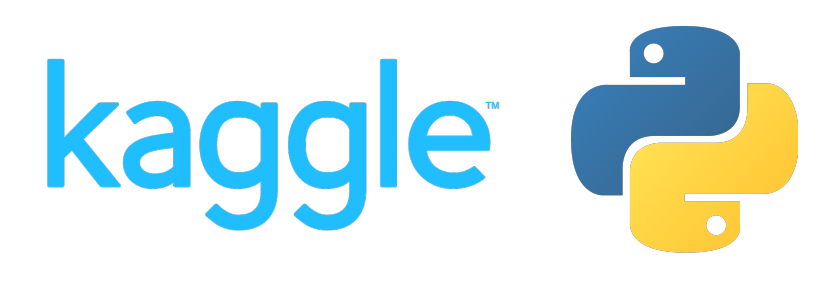

## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">Table of Content</p>

* [1. Data visualization 📊](#1)
    * [1.1 Target](#1.1)
    * [1.2 Numerical Columns](#1.2)
    * [1.3 Categorical Columns](#1.3)
* [2. Feature Engineering 🔧](#2)
* [3. Base Model ⚙️](#3)
    * [3.1 XGBoost](#3.1)
    * [3.2 LGBM](#3.2)
    * [3.3 LGBM: Cross-Validation](#3.3)
* [4. Optuna Optimization: LGBM ⚙️](#4)
    * [4.1 Study Visualization 📈](#4.1)
    * [4.2 Optuna Submission 📝](#4.2)
* [5. H2O AutoML 🧮](#5)
    * [5.1 H2O AutoML Submission 📝](#5.1)
* [6. LGBM Optimized CrossValidatied](#6)
* [7. Fianl Submission](#7)

In [3]:
train_df = pd.read_csv('/kaggle/input/tabular-playground-series-feb-2021/train.csv')
test_df = pd.read_csv('/kaggle/input/tabular-playground-series-feb-2021/test.csv')
sub_df = pd.read_csv('/kaggle/input/tabular-playground-series-feb-2021/sample_submission.csv')

train_df.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,A,B,A,A,B,D,A,E,C,...,0.881122,0.421650,0.741413,0.895799,0.802461,0.724417,0.701915,0.877618,0.719903,6.994023
1,2,B,A,A,A,B,B,A,E,A,...,0.440011,0.346230,0.278495,0.593413,0.546056,0.613252,0.741289,0.326679,0.808464,8.071256
2,3,A,A,A,C,B,D,A,B,C,...,0.914155,0.369602,0.832564,0.865620,0.825251,0.264104,0.695561,0.869133,0.828352,5.760456
3,4,A,A,A,C,B,D,A,E,G,...,0.934138,0.578930,0.407313,0.868099,0.794402,0.494269,0.698125,0.809799,0.614766,7.806457
4,6,A,B,A,A,B,B,A,E,C,...,0.382600,0.705940,0.325193,0.440967,0.462146,0.724447,0.683073,0.343457,0.297743,6.868974


In [4]:
feature_cols = train_df.drop(['id', 'target'], axis=1).columns

## Getting all the data that are not of "object" type. 
numerical_columns = train_df[feature_cols].select_dtypes(include=['int64','float64']).columns
categorical_columns = train_df[feature_cols].select_dtypes(exclude=['int64','float64']).columns

In [5]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_indexs = train_df.index
test_indexs = test_df.index

df =  pd.concat(objs=[train_df, test_df], axis=0).reset_index(drop=True)
df = df.drop('id', axis=1)

<a id='1'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">1. Data visualization 📊</p>

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 25 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cat0    500000 non-null  object 
 1   cat1    500000 non-null  object 
 2   cat2    500000 non-null  object 
 3   cat3    500000 non-null  object 
 4   cat4    500000 non-null  object 
 5   cat5    500000 non-null  object 
 6   cat6    500000 non-null  object 
 7   cat7    500000 non-null  object 
 8   cat8    500000 non-null  object 
 9   cat9    500000 non-null  object 
 10  cont0   500000 non-null  float64
 11  cont1   500000 non-null  float64
 12  cont2   500000 non-null  float64
 13  cont3   500000 non-null  float64
 14  cont4   500000 non-null  float64
 15  cont5   500000 non-null  float64
 16  cont6   500000 non-null  float64
 17  cont7   500000 non-null  float64
 18  cont8   500000 non-null  float64
 19  cont9   500000 non-null  float64
 20  cont10  500000 non-null  float64
 21  cont11  50

<a id='1.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">1.1 Target Variable</p>

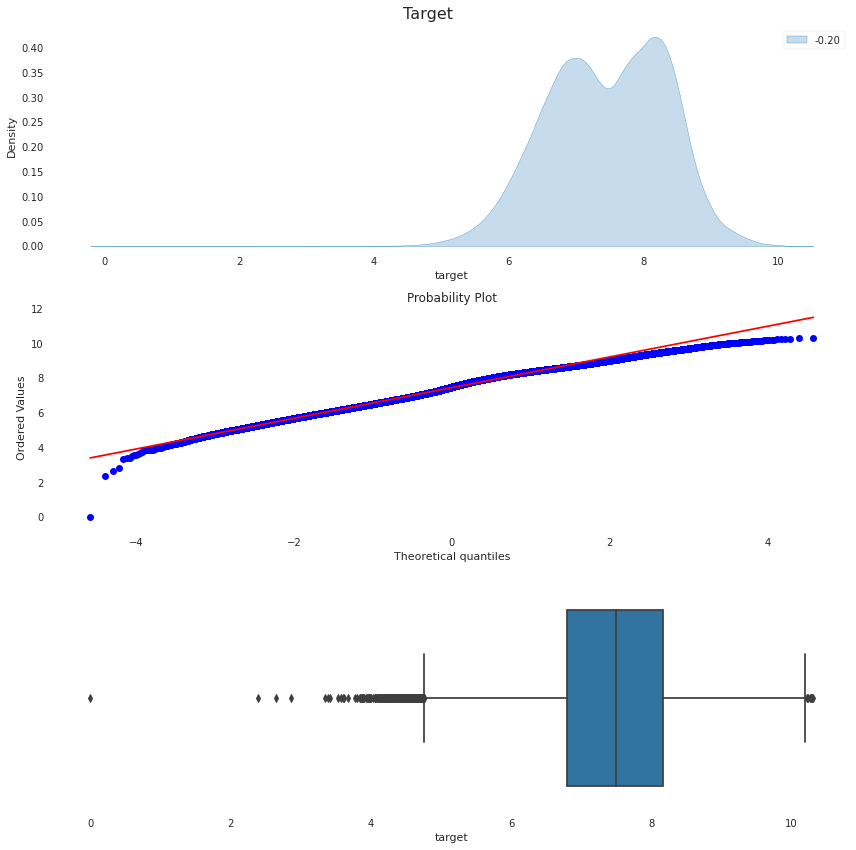

In [7]:
f, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))

f.suptitle('Target', fontsize=16)
g = sns.kdeplot(train_df['target'], shade=True, label="%.2f"%(train_df['target'].skew()), ax=axes[0])
g = g.legend(loc="best")
stats.probplot(train_df['target'], plot=axes[1])
sns.boxplot(x='target', data=train_df, orient='h', ax=axes[2]);

plt.tight_layout()
plt.show()

<a id='1.2'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">1.2 Numerical Variables</p>

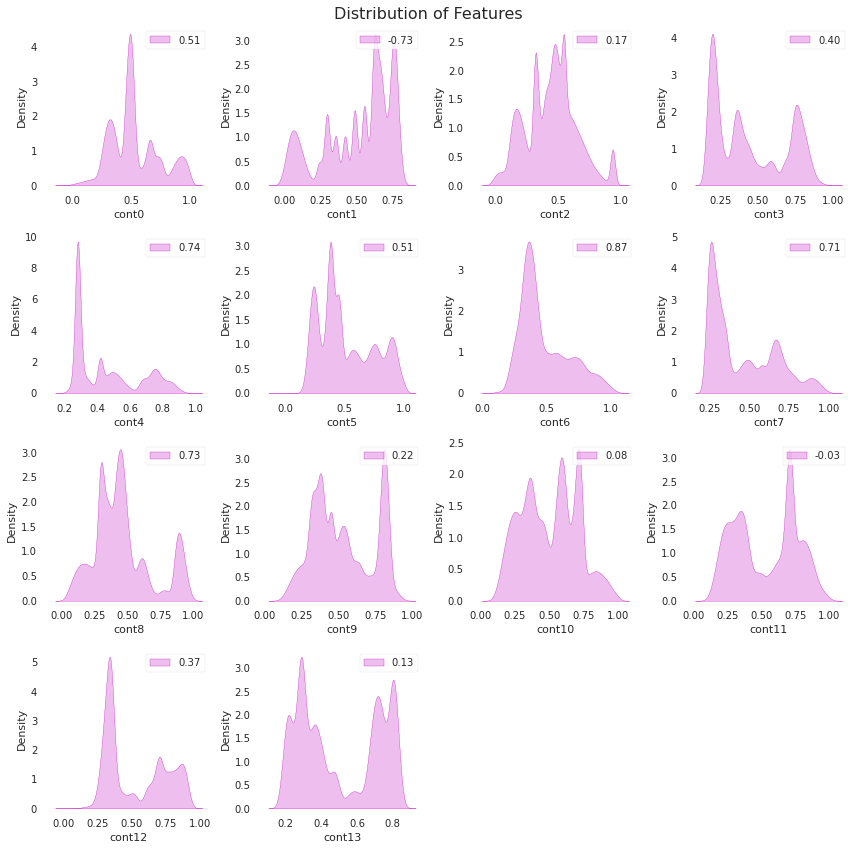

In [8]:
num_rows, num_cols = 4,4
f, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 12))
f.suptitle('Distribution of Features', fontsize=16)

for index, column in enumerate(df[numerical_columns].columns):
    i,j = (index // num_cols, index % num_cols)
    g = sns.kdeplot(train_df[column], color="m", shade=True, label="%.2f"%(train_df[column].skew()), ax=axes[i,j])
    g = g.legend(loc="best")

f.delaxes(axes[3, 2])
f.delaxes(axes[3, 3])
plt.tight_layout()
plt.show()

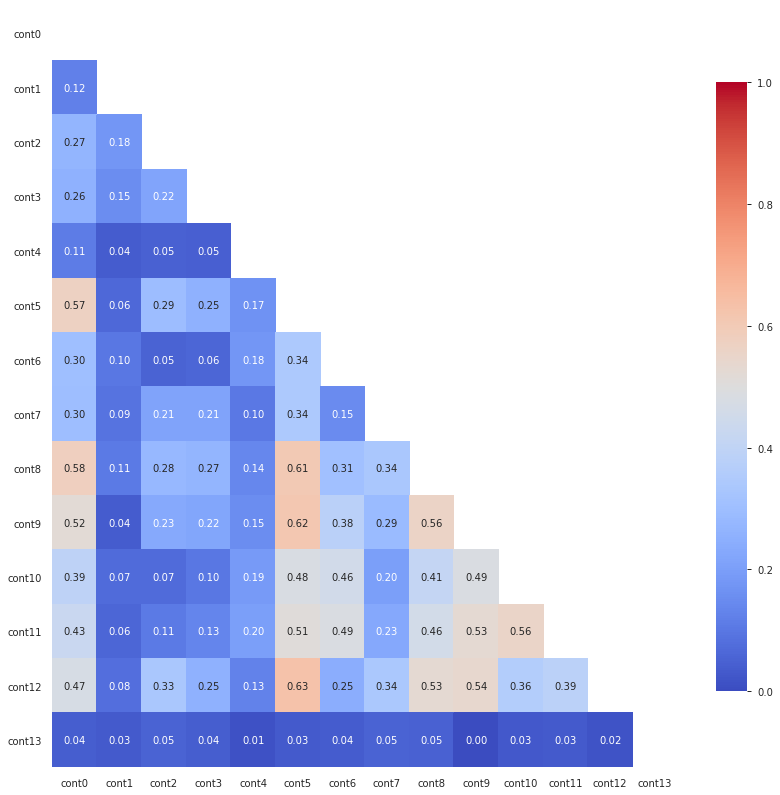

In [9]:
corr = df[numerical_columns].corr().abs()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig, ax = plt.subplots(figsize=(14, 14))

# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            cbar_kws={"shrink": .8}, vmin=0, vmax=1)
# yticks
plt.yticks(rotation=0)
plt.show()

As we can see, there is no high correlation between variables

<a id='1.3'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">1.3 Categorical Variables</p>

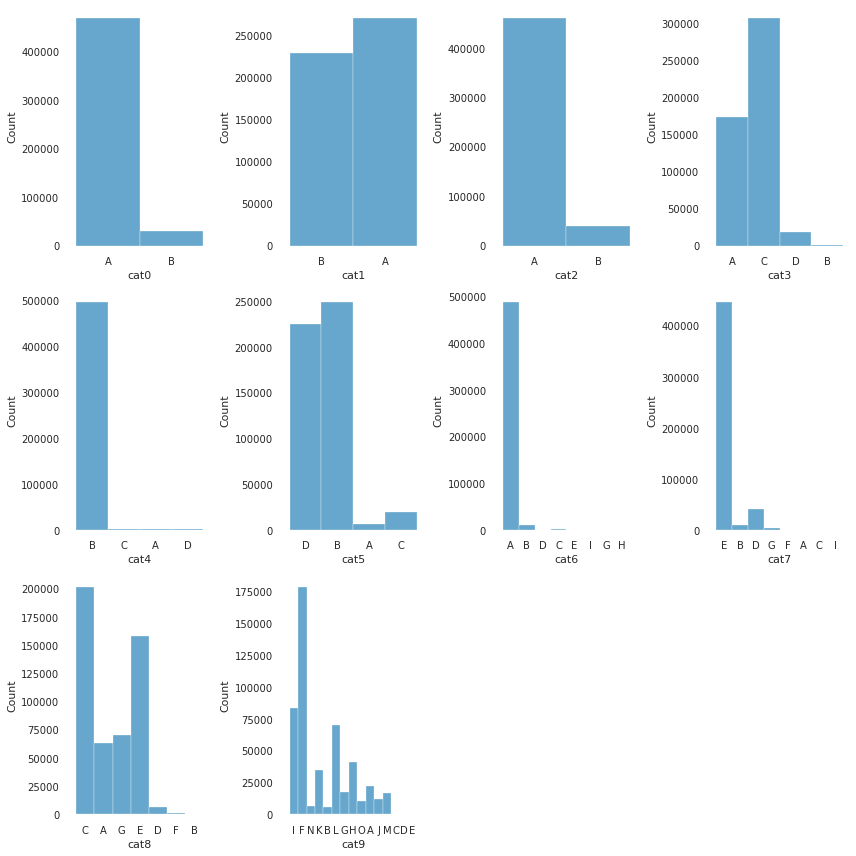

In [10]:
num_rows, num_cols = 3,4
f, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 12))
#f.suptitle('Distribution of Features', fontsize=16)

for index, column in enumerate(df[categorical_columns].columns):
    i,j = (index // num_cols, index % num_cols)
    sns.histplot(x=column, data=df, ax=axes[i,j])

f.delaxes(axes[2, 2])
f.delaxes(axes[2, 3])
plt.tight_layout()
plt.show()

<a id='2'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">2. Feature Engineering 🔧</p>

### Label Encoder
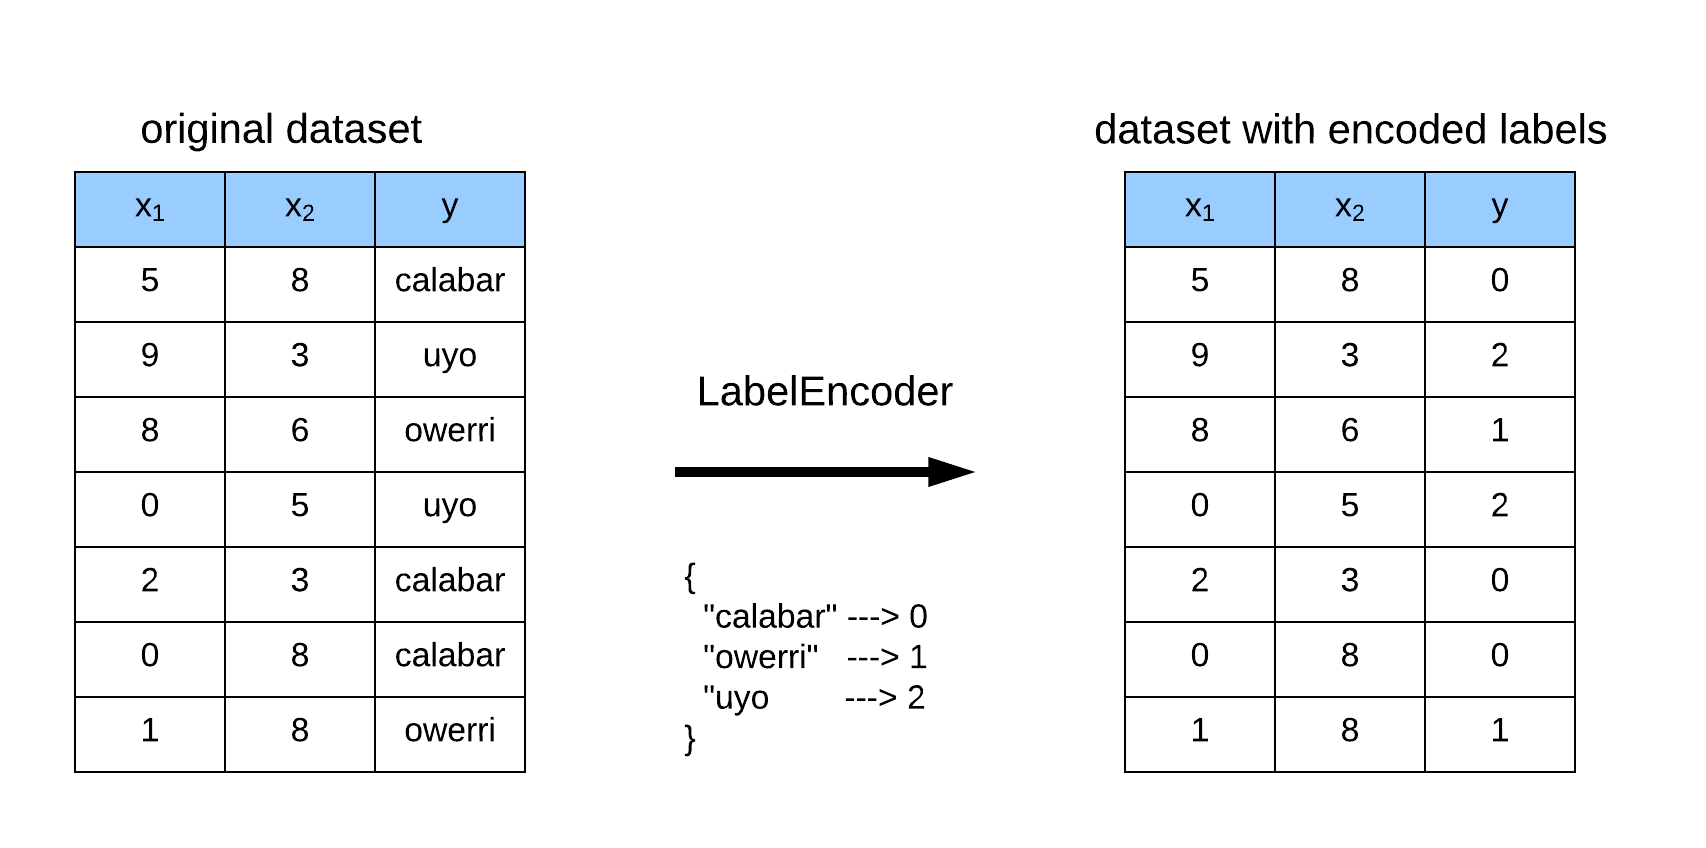

In [11]:
for feature in categorical_columns:
    le = LabelEncoder()
    le.fit(train_df[feature])
    train_df[feature] = le.transform(train_df[feature])
    test_df[feature] = le.transform(test_df[feature])

<a id='3'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">3. Base Model ⚙️</p>

In [12]:
x = train_df[feature_cols]
y = train_df['target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

<a id='3.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">3.1 Base XGBoost</p>

In [13]:
# Instantiate model with 100 decision trees
clf = XGBRegressor(random_state=42, tree_method='gpu_hist')

clf.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [14]:
# Use the forest's predict method on the test data
predictions = clf.predict(x_test)

score_rmse = math.sqrt(mean_squared_error(y_test, predictions))
print(Fore.GREEN + 'Base XGBoost RMSE: {}'.format(score_rmse))

Base XGBoost RMSE: 0.8513526629620365


In [15]:
sub_xgb_base = clf.predict(test_df[feature_cols])

<a id='3.2'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">3.2 Base LGBM</p>

In [16]:
# Instantiate model with 100 decision trees
clf = LGBMRegressor(random_state=42, device='gpu')

clf.fit(x_train, y_train)

LGBMRegressor(device='gpu', random_state=42)

In [17]:
# Use the forest's predict method on the test data
predictions = clf.predict(x_test)

score_rmse = math.sqrt(mean_squared_error(y_test, predictions))
print(Fore.GREEN + 'Base LGBM RMSE: {}'.format(score_rmse))

Base LGBM RMSE: 0.8475616976181732


<a id='3.3'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">3.2 Base LGBM Cross Validation</p>

In [18]:
train_oof = np.zeros((300000,))
test_preds = 0
train_oof.shape

(300000,)

In [19]:
NUM_FOLDS = 5
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=0)

for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(x, y))):
        tmp_train_df, tmp_val_df = x.iloc[train_ind][feature_cols], x.iloc[val_ind][feature_cols]
        train_target, val_target = y[train_ind], y[val_ind]
        
        model = LGBMRegressor(random_state=42, device='gpu')
        model.fit(tmp_train_df, train_target, eval_set=[(tmp_val_df, val_target)], verbose=False)
        temp_oof = model.predict(tmp_val_df)
        temp_test = model.predict(test_df[feature_cols])

        train_oof[val_ind] = temp_oof
        test_preds += temp_test/NUM_FOLDS
        
        print(mean_squared_error(temp_oof, val_target, squared=False))

|          | 0/? [00:00<?, ?it/s]

0.8471018103979598
0.8449124899822527
0.847207061528795
0.8450652144221356
0.8480787750475173


In [20]:
sub_df['target'] = test_preds
sub_df.to_csv('submission_lgbm_cv.csv', index=False)
sub_df.head()

sub_lgbm_cv = test_preds

<a id='4'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">4. Optuna Optimization: LGBM ⚙️</p>

In [21]:
def objective(trial,data=x,target=y):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=42)
    
    # To select which parameters to optimize, please look at the XGBoost documentation:
    # https://xgboost.readthedocs.io/en/latest/parameter.html
    param = {
        'device':'gpu',  # Use GPU acceleration
        'metric': 'rmse',
        'random_state': 42,
        'reg_lambda': trial.suggest_loguniform(
            'reg_lambda', 1e-3, 10.0
        ),
        'reg_alpha': trial.suggest_loguniform(
            'reg_alpha', 1e-3, 10.0
        ),
        'colsample_bytree': trial.suggest_categorical(
            'colsample_bytree', [0.3,0.5,0.6,0.7,0.8,0.9,1.0]
        ),
        'subsample': trial.suggest_categorical(
            'subsample', [0.6,0.7,0.8,1.0]
        ),
        'learning_rate': trial.suggest_categorical(
            'learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]
        ),
        'n_estimators': trial.suggest_categorical(
            "n_estimators", [150, 200, 300, 3000]
        ),
        'max_depth': trial.suggest_categorical(
            'max_depth', [4,5,7,9,11,13,15,17,20]
        ),
        'min_child_samples': trial.suggest_int(
            'min_child_samples', 1, 300
        ),
        'num_leaves': trial.suggest_int(
            'num_leaves', 15, 120
        ),
    }
    model = LGBMRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)], early_stopping_rounds=300, verbose=False)
    
    preds = model.predict(test_x)
    
    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse

In [22]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2021-02-14 01:02:59,341] A new study created in memory with name: no-name-13ad59bf-57bf-4000-b672-60c6605e494c
[I 2021-02-14 01:03:07,650] Trial 0 finished with value: 0.850845900671783 and parameters: {'reg_lambda': 2.826111099439424, 'reg_alpha': 1.9288685965484509, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.02, 'n_estimators': 200, 'max_depth': 15, 'min_child_samples': 271, 'num_leaves': 94}. Best is trial 0 with value: 0.850845900671783.
[I 2021-02-14 01:03:16,650] Trial 1 finished with value: 0.8565337146262167 and parameters: {'reg_lambda': 0.03972353539444539, 'reg_alpha': 0.0019222846780563325, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.009, 'n_estimators': 300, 'max_depth': 9, 'min_child_samples': 260, 'num_leaves': 54}. Best is trial 0 with value: 0.850845900671783.
[I 2021-02-14 01:04:30,178] Trial 2 finished with value: 0.8447451347050281 and parameters: {'reg_lambda': 0.18877864567974406, 'reg_alpha': 0.08107647880376018, 'colsample

Number of finished trials: 5
Best trial: {'reg_lambda': 6.090064325463461, 'reg_alpha': 0.003411651495990647, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 3000, 'max_depth': 9, 'min_child_samples': 297, 'num_leaves': 93}


In [23]:
study.trials_dataframe().head()

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_samples,params_n_estimators,params_num_leaves,params_reg_alpha,params_reg_lambda,params_subsample,state
0,0,0.850846,2021-02-14 01:02:59.345204,2021-02-14 01:03:07.649341,0 days 00:00:08.304137,0.8,0.020,15,271,200,94,1.928869,2.826111,1.0,COMPLETE
1,1,0.856534,2021-02-14 01:03:07.651209,2021-02-14 01:03:16.649679,0 days 00:00:08.998470,0.6,0.009,9,260,300,54,0.001922,0.039724,0.7,COMPLETE
2,2,0.844745,2021-02-14 01:03:16.651579,2021-02-14 01:04:30.177372,0 days 00:01:13.525793,0.7,0.009,7,165,3000,87,0.081076,0.188779,0.6,COMPLETE
3,3,0.844431,2021-02-14 01:04:30.185667,2021-02-14 01:05:42.062598,0 days 00:01:11.876931,0.6,0.010,9,297,3000,93,0.003412,6.090064,0.7,COMPLETE
4,4,0.868787,2021-02-14 01:05:42.071496,2021-02-14 01:05:46.072213,0 days 00:00:04.000717,1.0,0.009,5,130,150,38,0.260627,0.169499,1.0,COMPLETE


<a id='4.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">4.1 Study visualization 📈</p>

In [24]:
# plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
optuna.visualization.plot_optimization_history(study)

In [25]:
# plot feature importance for algorithm parameters
visualization.plot_param_importances(study)

In [26]:
#Visualize empirical distribution function
optuna.visualization.plot_edf(study)

In [27]:
# finally plot best parameters
study.best_params

{'reg_lambda': 6.090064325463461,
 'reg_alpha': 0.003411651495990647,
 'colsample_bytree': 0.6,
 'subsample': 0.7,
 'learning_rate': 0.01,
 'n_estimators': 3000,
 'max_depth': 9,
 'min_child_samples': 297,
 'num_leaves': 93}

<a id='4.2'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">4.2 Optimized LGBM 📝</p>

In [28]:
best_params = {
    'reg_lambda': 0.015979956459638782,
    'reg_alpha': 9.103977313355028,
    'colsample_bytree': 0.3,
    'subsample': 1.0,
    'learning_rate': 0.009,
    'n_estimators': 3000,
    'max_depth': 15,
    'min_child_samples': 142,
    'num_leaves': 84,
    'random_state': 42, 
    'device': 'gpu',
}

# Instantiate model with 100 decision trees
clf = LGBMRegressor(**best_params)

clf.fit(x_train, y_train)

# Use the forest's predict method on the test data
predictions = clf.predict(x_test)

score_rmse = math.sqrt(mean_squared_error(y_test, predictions))
print(Fore.GREEN + 'Base LGBM RMSE: {}'.format(score_rmse))

Base LGBM RMSE: 0.8436760586537242


<a id='4.3'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">4.3 Optuna Submission 📝</p>

In [29]:
sub_preds = clf.predict(test_df[feature_cols])

sub_df['target'] = sub_preds
sub_df.to_csv('submission_lgbm_optuna.csv', index=False)
sub_df.head()

sub_lgbm_optuna = sub_preds

<a id='5'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">5. Optimized LGBM CrossValidated 🧮</p>

In [30]:
lgbm_params = {
    "random_state": 2021,
    "metric": "rmse",
    "n_jobs": -1,
    "cat_feature": [x for x in range(len(categorical_columns))],
    "early_stopping_round": 150,
    "reg_alpha": 6.147694913504962,
    "reg_lambda": 0.002457826062076097,
    "colsample_bytree": 0.3,
    "learning_rate": 0.01,
    "max_depth": 30,
    "num_leaves": 100,
    "min_child_samples": 275,
    "n_estimators": 30000,
    "cat_smooth": 40.0,
    "max_bin": 512,
    "min_data_per_group": 100,
    "bagging_freq": 1,
    "bagging_fraction": 0.7,
    "cat_l2": 12.0,
}

In [31]:
train_oof = np.zeros((300000,))
test_preds = 0
train_oof.shape

NUM_FOLDS = 10
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(x, y))):
        tmp_train_df, tmp_val_df = x.iloc[train_ind][feature_cols], x.iloc[val_ind][feature_cols]
        train_target, val_target = y[train_ind], y[val_ind]
        
        model = LGBMRegressor(**lgbm_params)
        model.fit(
            tmp_train_df, 
            train_target, 
            eval_set=[(tmp_val_df, val_target)], 
            verbose=False
        )
        
        temp_oof = model.predict(tmp_val_df)
        temp_test = model.predict(test_df[feature_cols])

        train_oof[val_ind] = temp_oof
        test_preds += temp_test/NUM_FOLDS
        
        print(mean_squared_error(temp_oof, val_target, squared=False))

|          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
0.8447523136690115
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



0.8383148954270055
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



0.8447608490376868
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



0.8424081379764321
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



0.840751801171369
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



0.8436175393432145
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



0.8415343222517084
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



0.8411302613373675
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



0.84226110290696
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



0.8388082105199479


In [32]:
sub_df['target'] = test_preds
sub_df.to_csv('submission_lgbm_cv_optimized.csv', index=False)
sub_df.head()

sub_lgbm_cv_optimized = test_preds

<a id='6'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">6. H2O AutoML 🧮</p>

In [33]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.10" 2021-01-19; OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmplyjrl0hh
  JVM stdout: /tmp/tmplyjrl0hh/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmplyjrl0hh/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.4
H2O_cluster_version_age:,12 days
H2O_cluster_name:,H2O_from_python_unknownUser_qey7l5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.250 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [34]:
train_hf = h2o.H2OFrame(train_df)
test_hf = h2o.H2OFrame(test_df)

predictors = list(feature_cols)
response = 'target'

# Split into train and test
train, valid = train_hf.split_frame(ratios=[.8], seed=1234)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [35]:
aml = H2OAutoML(
    max_models=20,
    max_runtime_secs=400,
    seed=42
)

In [36]:
# Train the model
aml.train(x=predictors,
        y=response,
        training_frame=train,
        validation_frame=valid
)

AutoML progress: |
01:30:44.160: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

████████████████████████████████████████████████████████| 100%


In [37]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20210214_013044,0.728337,0.853427,0.728337,0.712783,0.103498
StackedEnsemble_BestOfFamily_AutoML_20210214_013044,0.730117,0.854469,0.730117,0.713498,0.103629
XGBoost_3_AutoML_20210214_013044,0.739946,0.860201,0.739946,0.720071,0.10389
GBM_grid__1_AutoML_20210214_013044_model_1,0.740788,0.86069,0.740788,0.720797,0.104419
DeepLearning_1_AutoML_20210214_013044,0.754792,0.868787,0.754792,0.725166,0.105363
GLM_1_AutoML_20210214_013044,0.761083,0.872401,0.761083,0.729159,0.105822
GBM_3_AutoML_20210214_013044,0.769524,0.877225,0.769524,0.734491,0.106379
GBM_2_AutoML_20210214_013044,0.769645,0.877294,0.769645,0.734476,0.106391
GBM_5_AutoML_20210214_013044,0.769795,0.877379,0.769795,0.734625,0.106397
GBM_4_AutoML_20210214_013044,0.770201,0.877611,0.770201,0.734861,0.106424


In [38]:
lb = lb.as_data_frame()
lb['model_type'] = lb['model_id'].apply(lambda x: x.split('_')[0])
fig = px.bar(
    lb, 
    x='model_id',
    y='rmse',
    color='model_type'
)
fig.show()

In [39]:
print('The model performance in RMSE: {}'.format(aml.leader.rmse(valid=True)))
print('The model performance in MAE: {}'.format(aml.leader.mae(valid=True)))

The model performance in RMSE: 0.8568426293706929
The model performance in MAE: 0.7145783267839174


<a id='5.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">5.1 H2O AutoML Submission 📝</p>

In [40]:
preds = aml.predict(test_hf).as_data_frame()
preds.head()

stackedensemble prediction progress: |████████████████████████████████████| 100%


,predict
0,7.584513
1,7.798336
2,7.626283
3,7.406702
4,7.611266


In [41]:
sub_df['target'] = preds['predict']
sub_df.to_csv('submission_h2o.csv', index=False)
sub_df.head()

sub_automl = preds['predict']

<a id='7'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">7. Final Submission</p>

In [42]:
sub1 = 0.1*sub_automl + 0.3*sub_lgbm_cv_optimized + 0.4*sub_lgbm_optuna + 0.1*sub_lgbm_cv + 0.1*sub_xgb_base
sub2 = 0.1*sub_automl + 0.4*sub_lgbm_cv_optimized + 0.3*sub_lgbm_optuna + 0.1*sub_lgbm_cv + 0.1*sub_xgb_base
sub3 = 0.2*sub_automl + 0.3*sub_lgbm_cv_optimized + 0.3*sub_lgbm_optuna + 0.1*sub_lgbm_cv + 0.1*sub_xgb_base

In [43]:
sub_df['target'] = sub1
sub_df.to_csv('submission_1.csv', index=False)

sub_df['target'] = sub2
sub_df.to_csv('submission_2.csv', index=False)

sub_df['target'] = sub3
sub_df.to_csv('submission_3.csv', index=False)